In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.dates as mdates
import matplotlib.cm as cm
from tslearn.metrics import cdist_dtw
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.patches as mpatches
from scipy.stats import f_oneway
from IPython.display import display
from scipy import stats
import yfinance as yf
from sklearn.metrics import pairwise_distances
import cvxpy as cp

In [42]:
final_features = pd.read_csv('top_features_df.csv')
final_features = final_features.set_index('Date')

In [43]:
# ------------------------------
# 1. Expanding standardization
# ------------------------------
def expanding_standardize(df, min_periods=24):
    """
    For each t, fit StandardScaler on data up to and including t.
    Returns standardized series aligned with df, NaNs for first (min_periods-1) rows.
    """
    X = df.values
    out = np.full_like(X, np.nan, dtype=float)
    for i in range(len(df)):
        if i + 1 < min_periods:
            continue
        scaler = StandardScaler()
        out[i, :] = scaler.fit_transform(X[:i + 1, :])[-1, :]
    return pd.DataFrame(out, index=df.index, columns=df.columns)

# ------------------------------
# 2. Window creation
# ------------------------------
def make_windows(X_df, window=12):
    X = X_df.values
    n = len(X) - window + 1
    Xw = np.array([X[i:i + window, :] for i in range(n)])   # shape (n, window, n_features)
    idx = X_df.index[window - 1:]                           # label each window by its end date
    return Xw, idx



In [45]:
# Standardize & make window
X_expanded = expanding_standardize(final_features, min_periods=24).dropna()
Xw, idx_w = make_windows(X_expanded, window=12)

In [46]:
# --- Step 1. Convert index safely ---
if isinstance(idx_w, pd.PeriodIndex):
    idx_w_dt = idx_w.to_timestamp()
else:
    idx_w_dt = pd.to_datetime(idx_w)

# --- Step 2. Fit only on training data ---
train_end = "2019-12"
train_mask = idx_w_dt <= pd.Timestamp(train_end)

Xw_train = Xw[train_mask]
idx_train = idx_w_dt[train_mask]
idx_test = idx_w_dt[~train_mask]

print(f"Training windows: {len(Xw_train)} / Total: {len(Xw)}")

Training windows: 323 / Total: 387


In [39]:
final_k = 5
final_model = TimeSeriesKMeans(
    n_clusters=final_k,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 1},
    n_init=3,
    max_iter=30,
    random_state=42
)
train_labels = final_model.fit_predict(Xw_train)
test_labels = final_model.predict(Xw[~train_mask])

# --- Step 3. Build regime dataframe (use datetime index) ---
regime_df = pd.DataFrame({"Regime": list(train_labels) + list(test_labels)}, index=idx_w_dt)

In [40]:
regime_df.to_csv('kmeans_output.csv')

Merged successfully — regime counts:
Regime
2.0    156
1.0    103
4.0     78
0.0     32
3.0     18
NaN     11
Name: count, dtype: int64


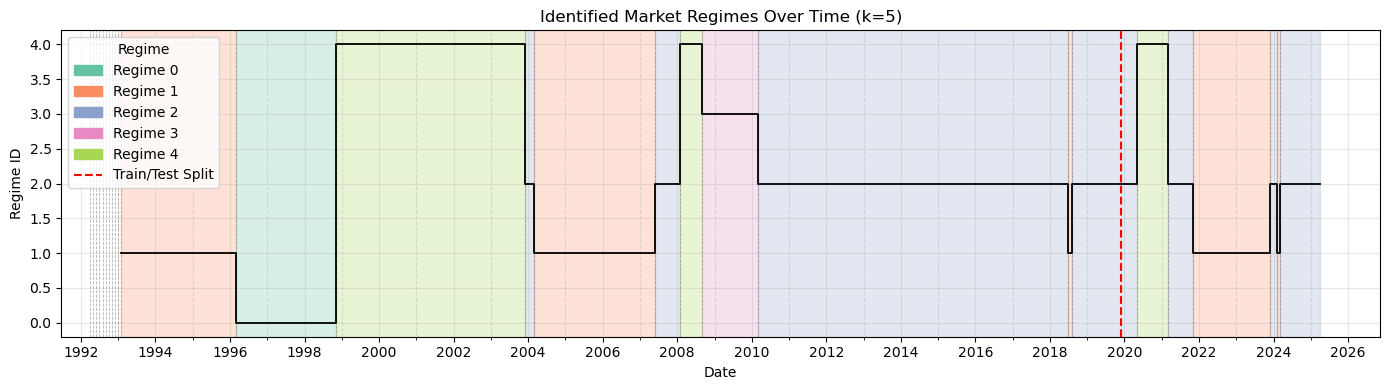

In [36]:
# --- Align with monthly data (forward fill to cover all months) ---
regime_monthly = regime_df.reindex(X_expanded.index, method="ffill")
X_with_regime = X_expanded.copy()
X_with_regime["Regime"] = regime_monthly["Regime"]

print("Merged successfully — regime counts:")
print(X_with_regime["Regime"].value_counts(dropna=False))

# --- Prepare for plotting ---
x = pd.to_datetime(X_with_regime.index)
vals = X_with_regime["Regime"].values
unique_regs = sorted(X_with_regime["Regime"].dropna().unique())
palette = sns.color_palette("Set2", n_colors=len(unique_regs))
colors = dict(zip(unique_regs, palette))

# --- Identify regime segments ---
seg_starts = [x[0]]
seg_labels = [vals[0]]
for i in range(1, len(vals)):
    if vals[i] != vals[i - 1]:
        seg_starts.append(x[i])
        seg_labels.append(vals[i])
seg_ends = seg_starts[1:] + [x[-1]]

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(x, vals, where="post", color="black", lw=1.3, zorder=3)

ymin, ymax = ax.get_ylim()
for s, e, lab in zip(seg_starts, seg_ends, seg_labels):
    if not np.isnan(lab):
        ax.axvspan(s, e, color=colors.get(lab, "grey"), alpha=0.25, zorder=1)

# --- Mark regime change boundaries ---
for s in seg_starts[1:]:
    ax.axvline(s, color="grey", lw=0.6, alpha=0.6, linestyle="--")

# --- Add train/test split line ---
ax.axvline(pd.Timestamp(train_end), color="red", linestyle="--", lw=1.5, label="Train/Test Split")

# --- Legend ---
handles = [mpatches.Patch(color=colors[r], label=f"Regime {int(r)}") for r in unique_regs]
# handles.append(mpatches.Patch(color="none", label="-- Train/Test Split"))
handles.append(
    plt.Line2D(
        [0], [0],
        color="red",
        lw=1.5,
        linestyle="--",
        label="Train/Test Split"
    )
)
ax.legend(handles=handles, title="Regime", loc="upper left")

# --- Titles & labels ---
ax.set_title(f"Identified Market Regimes Over Time (k={final_k})")
ax.set_xlabel("Date")
ax.set_ylabel("Regime ID")
ax.grid(alpha=0.3)

# --- Year grid setup ---
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.grid(True, which='minor', axis='x', linestyle='--', alpha=0.4)
ax.xaxis.set_major_locator(mdates.YearLocator(2))          # show every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

In [48]:
def summarize_core_regimes_separate(X_with_regime, split_date="2019-12"):
    """
    Summarize regimes using one key indicator per macro dimension.
    Display train and test summaries separately.
    """
    # --- Core features: one per macro pillar ---
    core_features = [
        "INDPRO",           # Growth
        "CUSR0000SAS",      # Inflation
        "USGG2YR Index",    # Policy / rates
        "LUACOAS Index",    # Credit spreads
        "VIX Index",        # Market volatility
        "CAPE"              # Valuation
    ]
    available = [f for f in core_features if f in X_with_regime.columns]

    df = X_with_regime.dropna(subset=["Regime"]).copy()
    df.index = pd.to_datetime(df.index)
    split = pd.Timestamp(split_date)

    # --- Split train / test ---
    train_df = df[df.index <= split]
    test_df  = df[df.index > split]

    print(f"Train period: {train_df.index.min().strftime('%Y-%m')} → {train_df.index.max().strftime('%Y-%m')} "
          f"({len(train_df):,} obs)")
    print(f"Test  period: {test_df.index.min().strftime('%Y-%m')} → {test_df.index.max().strftime('%Y-%m')} "
          f"({len(test_df):,} obs)\n")

    # --- Helper to compute mean ± std ---
    def regime_summary(df):
        g = df.groupby("Regime")[available]
        mean, std = g.mean().round(2), g.std().round(2)
        summary = mean.astype(str) + " ± " + std.astype(str)
        return summary, mean

    # --- Train summary ---
    train_summary_str, train_mean = regime_summary(train_df)
    print("=== TRAIN PERIOD SUMMARY (≤ Split) ===")
    display(train_summary_str)

    # --- Test summary ---
    test_summary_str, test_mean = regime_summary(test_df)
    print("\n=== TEST PERIOD SUMMARY (> Split) ===")
    display(test_summary_str)

    # --- Visualize side-by-side heatmaps for context ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    sns.heatmap(train_mean.T, cmap="RdYlGn", center=0, ax=axes[0], annot=True, fmt=".2f")
    axes[0].set_title("Train Data (≤ Split)")
    sns.heatmap(test_mean.T, cmap="RdYlGn", center=0, ax=axes[1], annot=True, fmt=".2f")
    axes[1].set_title("Test Data (> Split)")

    for ax in axes:
        ax.set_xlabel("Regime")
        ax.set_ylabel("Indicator")

    plt.suptitle("Core Macro & Market Indicators by Regime", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return train_summary_str, test_summary_str

Train period: 1993-02 → 2019-12 (323 obs)
Test  period: 2020-01 → 2025-04 (64 obs)

=== TRAIN PERIOD SUMMARY (≤ Split) ===


,INDPRO,CUSR0000SAS,USGG2YR Index,LUACOAS Index,VIX Index,CAPE
Regime,,,,,,
0.0,0.43 ± 1.0,0.01 ± 0.6,-0.03 ± 0.82,-0.64 ± 1.07,1.28 ± 1.13,0.19 ± 1.78
1.0,0.16 ± 0.99,0.02 ± 0.97,0.36 ± 0.88,-0.72 ± 0.41,-0.82 ± 0.37,0.05 ± 0.69
2.0,-0.09 ± 0.72,0.02 ± 0.65,0.03 ± 0.62,0.13 ± 0.54,-0.34 ± 0.69,0.04 ± 0.77
3.0,-1.01 ± 2.47,-0.03 ± 0.78,-0.18 ± 0.85,3.0 ± 2.41,1.94 ± 1.7,-0.09 ± 1.28
4.0,-0.47 ± 0.96,-0.0 ± 1.21,0.02 ± 1.05,1.93 ± 1.0,0.83 ± 0.72,-0.27 ± 1.46



=== TEST PERIOD SUMMARY (> Split) ===


,INDPRO,CUSR0000SAS,USGG2YR Index,LUACOAS Index,VIX Index,CAPE
Regime,,,,,,
1.0,0.01 ± 0.5,-0.06 ± 1.26,0.75 ± 1.47,-0.08 ± 0.24,0.19 ± 0.79,-0.29 ± 1.31
2.0,-0.72 ± 3.01,-0.06 ± 1.21,-0.28 ± 1.0,-0.42 ± 0.53,0.05 ± 1.2,-0.07 ± 1.55
4.0,1.04 ± 2.36,0.46 ± 1.75,0.07 ± 0.1,-0.13 ± 0.35,1.07 ± 0.66,0.92 ± 0.62


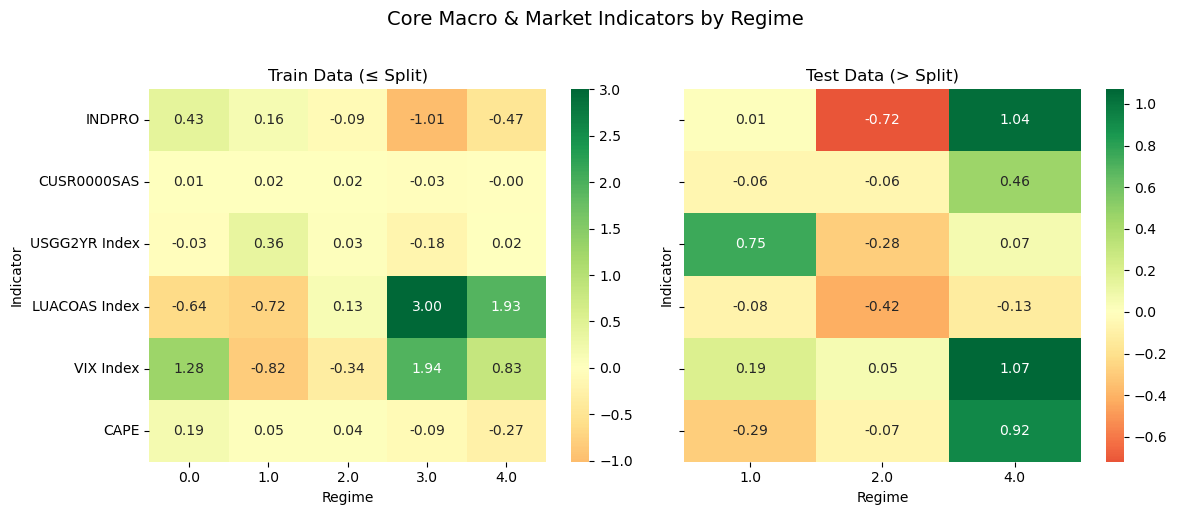

In [50]:
train_summary, test_summary = summarize_core_regimes_separate(X_with_regime, split_date="2019-12")

In [51]:
regime_labels = {
    0: "Stagflation / Stress Shock",
    1: "Normal / Low-Vol Expansion",
    2: "Overheat / Inflationary Late-Cycle",
    3: "Transitional / Fragile Late-Cycle",
    4: "Recession / Crisis"
}
X_with_regime["Regime_Label"] = X_with_regime["Regime"].map(regime_labels)

In [11]:
df_px = pd.read_csv("df_px_final.csv")

In [47]:
# ============================================================
# 0. Safe data preparation (works whether Date is a column or index)
# ============================================================
if "Date" in df_px.columns:
    df_px = df_px.copy()
    df_px["Date"] = pd.to_datetime(df_px["Date"])
    df_px = df_px.set_index("Date").sort_index()
else:
    df_px = df_px.copy()
    if not isinstance(df_px.index, pd.DatetimeIndex):
        df_px.index = pd.to_datetime(df_px.index)
    df_px = df_px.sort_index()

regime_df = regime_df.copy().sort_index()
if not isinstance(regime_df.index, pd.DatetimeIndex):
    regime_df.index = pd.to_datetime(regime_df.index)


# ============================================================
# 1. Build “true” vs “tradable” regime timelines
# ============================================================
# Regime_true = actual regime label for that month (for interpretation)
# Regime_signal = previous month's regime, tradable at the start of this month

regime_df["Regime_true"] = regime_df["Regime"]
regime_df["Regime_signal"] = regime_df["Regime"].shift(1)

# Comment:
# - Regime_true is for plotting or explaining economic phases.
# - Regime_signal is for portfolio allocation (the only one usable in real time).

# ============================================================
# 2. Merge shifted regimes with daily price data
# ============================================================
df_regime = (
    pd.merge_asof(
        df_px.reset_index(),
        regime_df[["Regime_true", "Regime_signal"]].reset_index().rename(columns={"Date": "Regime_Date"}),
        left_on="Date",
        right_on="Regime_Date",
        direction="backward"
    )
    .set_index("Date")
    .drop(columns=["Regime_Date"])
    .ffill()
)

# ============================================================
# 3. Compute daily returns
# ============================================================
ret_d = df_px.pct_change().dropna()

# ============================================================
# 4. Define benchmark weights and groups
# ============================================================
bench_w = {
    "Russell 1000 Value": 0.25,
    "Russell 1000 Growth": 0.25,
    "Russell 2000": 0.10,
    "US Short-term Treasury": 0.10,
    "US Long-term Treasury": 0.10,
    "US IG Corporate Bond": 0.15,
    "US HY Corporate Bond": 0.05,
}
alloc_cols = list(bench_w.keys())

groups = {
    "Equity": ["Russell 1000 Value", "Russell 1000 Growth", "Russell 2000"],
    "Rates": ["US Short-term Treasury", "US Long-term Treasury"],
    "Credit": ["US IG Corporate Bond", "US HY Corporate Bond"],
}

bench = pd.Series(bench_w)

# ============================================================
# 5. Define helper for group totals and constraints
# ============================================================
def group_totals(w):
    return pd.Series({
        "Equity": w[groups["Equity"]].sum(),
        "Rates":  w[groups["Rates"]].sum(),
        "Credit": w[groups["Credit"]].sum(),
    })

# ============================================================
# 6. Forward 6-month returns (for regime-conditional stats)
# ============================================================
BDAY_6M = 126
fwd6m = df_px.shift(-BDAY_6M) / df_px - 1.0
fwd6m = fwd6m.dropna(how="all")

# ============================================================
# 7. Function: compute regime-conditional mean returns (past only)
# ============================================================
def past_regime_stats(decision_date):
    """
    Use only past samples whose forward 6-month return windows end before decision_date.
    """
    cutoff = decision_date - pd.offsets.BDay(0)
    valid_idx = fwd6m.index < cutoff
    reg_series = df_regime.reindex(fwd6m.index)["Regime_signal"]
    df_tmp = fwd6m.loc[valid_idx].copy()
    df_tmp["regime"] = reg_series.loc[valid_idx].values
    df_tmp = df_tmp.dropna(subset=["regime"])
    means = df_tmp.groupby("regime")[alloc_cols].mean()
    counts = df_tmp.groupby("regime")[alloc_cols].count()
    return means, counts

def shrink_table(means, counts, ridge=0.02):
    gmean = means.stack().mean()
    w = counts / (counts + ridge * counts.stack().mean())
    return w * means + (1 - w) * gmean

# ============================================================
# 8. Constrained optimizer (no-shorting, ±10% asset, ±5% sub-asset)
# ============================================================
def target_from_signals(mu):
    sig = pd.Series(0.0, index=alloc_cols)
    for g, names in groups.items():
        m = mu[names].dropna()
        if len(m) >= 2:
            z = (m - m.mean()) / (m.std(ddof=0) + 1e-8)
            sig.loc[m.index] = z

    w_des = bench + 0.05 * sig / (sig.abs().sum() + 1e-8)

    n = len(alloc_cols)
    w = cp.Variable(n)
    Aeq = np.ones((1, n))
    beq = np.array([1.0])
    constraints = [w >= 0, Aeq @ w == beq]

    # ±5% per asset
    for i, name in enumerate(alloc_cols):
        constraints += [w[i] >= bench[name] - 0.05,
                        w[i] <= bench[name] + 0.05]

    # ±10% per group
    for g, names in groups.items():
        idx = [alloc_cols.index(nm) for nm in names]
        constraints += [
            cp.sum(w[idx]) >= group_totals(bench)[g] - 0.10,
            cp.sum(w[idx]) <= group_totals(bench)[g] + 0.10,
        ]

    obj = cp.Minimize(cp.sum_squares(w - w_des.values))
    cp.Problem(obj, constraints).solve(solver=cp.ECOS, verbose=False)
    w_opt = np.maximum(0, w.value)
    return pd.Series(w_opt / w_opt.sum(), index=alloc_cols)

# ============================================================
# 9. Monthly rebalancing loop
# ============================================================
# Rebalance on the first business day of each month
month_starts = (
    ret_d.index.to_series()
    .groupby(ret_d.index.to_period("M"))
    .min()                # first actual trading day in that month
    .sort_values()
    .values
)
weights_m = {}


for m_start in month_starts:
    reg = df_regime.loc[m_start, "Regime_signal"]
    means, counts = past_regime_stats(m_start)
    if reg not in means.index:
        weights_m[m_start] = bench.copy()
        continue
    mu_reg = shrink_table(means, counts).loc[reg].reindex(alloc_cols)
    w_t = target_from_signals(mu_reg.fillna(0))
    weights_m[m_start] = w_t

w_m = pd.DataFrame(weights_m).T.sort_index()

# ============================================================
# 10. Convert to daily weights and compute returns
# ============================================================
def carry_to_daily(w_m, index_d):
    return w_m.reindex(index_d, method="ffill")

w_d = carry_to_daily(w_m, ret_d.index)
w_bench_d = pd.DataFrame([bench] * len(w_d), index=w_d.index)

port_r = (w_d * ret_d[alloc_cols]).sum(axis=1)
bench_r = (w_bench_d * ret_d[alloc_cols]).sum(axis=1)
excess_r = port_r - bench_r

# ============================================================
# 11. Risk metrics
# ============================================================
# ============================================================
# 11. Portfolio and benchmark performance summary table
# ============================================================

ann_factor = 252

# --- Annualized metrics ---
def perf_stats(returns):
    """Compute standard performance metrics for a daily return series."""
    cum = (1 + returns).cumprod()
    roll_max = cum.cummax()
    drawdown = 1 - cum / roll_max

    stats = {
        "Annualized Return": returns.mean() * ann_factor,
        "Volatility (Ann)": returns.std() * np.sqrt(ann_factor),
        "Sharpe Ratio": (returns.mean() / returns.std()) * np.sqrt(ann_factor)
                        if returns.std() > 0 else np.nan,
        "Max Drawdown": drawdown.max(),
    }
    return pd.Series(stats)

# ============================================================
# 12. Train / Test / Full summary breakdown
# ============================================================
train_end = pd.Timestamp("2019-12-31")
test_start = train_end + pd.offsets.BDay(1)
ann_factor = 252

# --- Helper functions ---
def perf_stats(returns):
    """Compute standard performance metrics for a daily return series."""
    cum = (1 + returns).cumprod()
    roll_max = cum.cummax()
    drawdown = 1 - cum / roll_max
    stats = {
        "Annualized Return": returns.mean() * ann_factor,
        "Volatility (Ann)": returns.std() * np.sqrt(ann_factor),
        "Sharpe Ratio": (returns.mean() / returns.std()) * np.sqrt(ann_factor)
                        if returns.std() > 0 else np.nan,
        "Max Drawdown": drawdown.max(),
    }
    return pd.Series(stats)

def excess_stats(port, bench):
    excess = port - bench
    info_ratio = excess.mean() * ann_factor / (excess.std() * np.sqrt(ann_factor))
    tracking_error = excess.std() * np.sqrt(ann_factor)
    excess_return = excess.mean() * ann_factor
    return pd.Series({
        "Excess Return (Ann)": excess_return,
        "Tracking Error": tracking_error,
        "Information Ratio": info_ratio,
    })

# --- Split returns ---
port_r_train = port_r.loc[:train_end]
bench_r_train = bench_r.loc[:train_end]
port_r_test  = port_r.loc[test_start:]
bench_r_test = bench_r.loc[test_start:]

# --- Compute each panel ---
train_port = perf_stats(port_r_train)
train_bench = perf_stats(bench_r_train)
train_ex = excess_stats(port_r_train, bench_r_train)

test_port = perf_stats(port_r_test)
test_bench = perf_stats(bench_r_test)
test_ex = excess_stats(port_r_test, bench_r_test)

full_port = perf_stats(port_r)
full_bench = perf_stats(bench_r)
full_ex = excess_stats(port_r, bench_r)

# --- Combine results ---
summary_full = pd.concat([
    pd.concat([train_port.rename("Train Portfolio"),
               train_bench.rename("Train Benchmark"),
               train_ex.rename("Train Excess")], axis=1),
    pd.concat([test_port.rename("Test Portfolio"),
               test_bench.rename("Test Benchmark"),
               test_ex.rename("Test Excess")], axis=1),
    pd.concat([full_port.rename("Full Portfolio"),
               full_bench.rename("Full Benchmark"),
               full_ex.rename("Full Excess")], axis=1),
], axis=1)

# --- Format percentage metrics nicely ---
percent_metrics = [
    "Annualized Return", "Volatility (Ann)",
    "Excess Return (Ann)", "Tracking Error", "Max Drawdown"
]

def fmt_val(x, is_percent):
    if pd.isna(x):
        return "—"
    return f"{x*100:.2f}%" if is_percent else f"{x:.2f}"

for m in summary_full.index:
    summary_full.loc[m] = [
        fmt_val(v, m in percent_metrics)
        for v in summary_full.loc[m]
    ]

display(summary_full)

/var/folders/n6/pz2q030s2892kgbyw470z2nm0000gn/T/ipykernel_36009/1227018306.py:292: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.85%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_full.loc[m] = [
/var/folders/n6/pz2q030s2892kgbyw470z2nm0000gn/T/ipykernel_36009/1227018306.py:292: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.75%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_full.loc[m] = [
/var/folders/n6/pz2q030s2892kgbyw470z2nm0000gn/T/ipykernel_36009/1227018306.py:292: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '—' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_full.loc[m] = [

,Train Portfolio,Train Benchmark,Train Excess,Test Portfolio,Test Benchmark,Test Excess,Full Portfolio,Full Benchmark,Full Excess
Annualized Return,5.85%,5.75%,—,5.97%,5.86%,—,5.87%,5.77%,—
Volatility (Ann),8.63%,8.64%,—,11.45%,11.47%,—,9.14%,9.15%,—
Sharpe Ratio,0.68,0.67,—,0.52,0.51,—,0.64,0.63,—
Max Drawdown,37.50%,37.88%,—,23.87%,23.96%,—,37.50%,37.88%,—
Excess Return (Ann),—,—,0.10%,—,—,0.11%,—,—,0.10%
Tracking Error,—,—,0.10%,—,—,0.15%,—,—,0.11%
Information Ratio,—,—,1.00,—,—,0.75,—,—,0.93


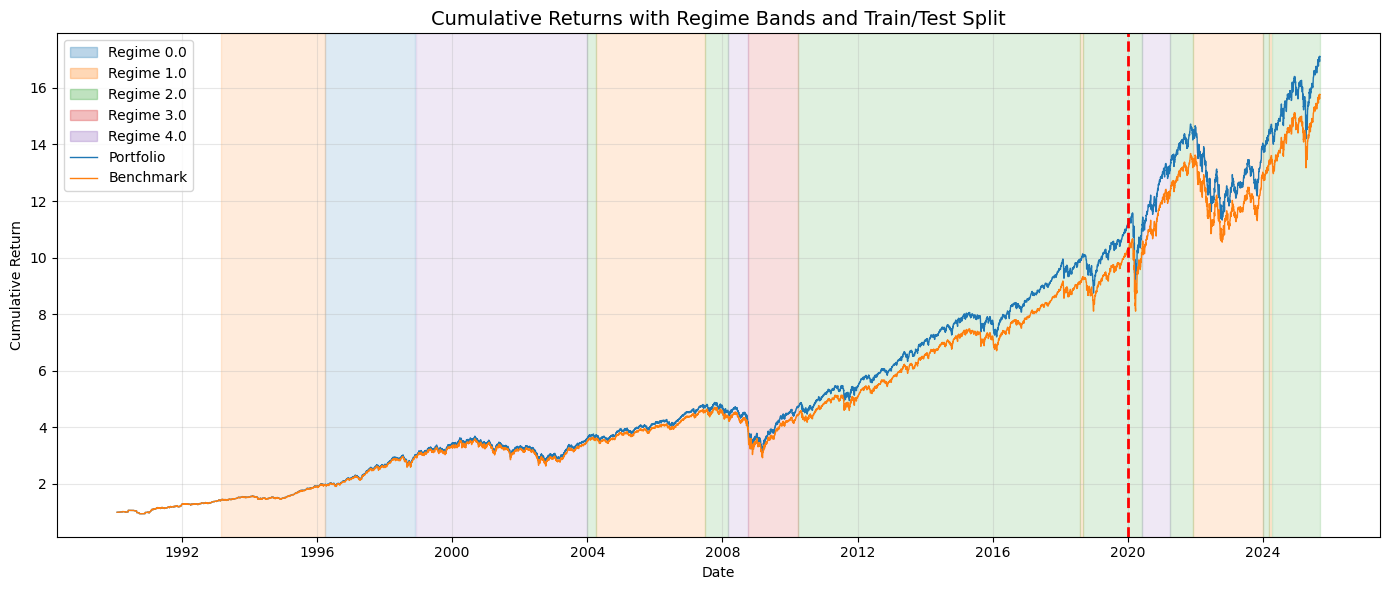

In [30]:
# ============================================================
# 13. Visualization: Regime bands with Train/Test Split (final clean version)
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Choose which regime to show ---
regime_col = "Regime_signal"   # or "Regime_true" if you merged both
train_end = pd.Timestamp("2019-12-31")

# --- Compute cumulative returns ---
cum_port = (1 + port_r).cumprod()
cum_bench = (1 + bench_r).cumprod()

# --- Align regime timeline to return index ---
regime_series = df_regime[regime_col].reindex(cum_port.index, method="ffill")

# --- Normalize cumulative returns to start at 1 ---
cum_port /= cum_port.iloc[0]
cum_bench /= cum_bench.iloc[0]

# --- Create figure ---
plt.figure(figsize=(14, 6))

# --- Plot cumulative returns ---
plt.plot(cum_port, label="Portfolio", linewidth=1)
plt.plot(cum_bench, label="Benchmark", linewidth=1)

# --- Overlay color bands for regimes ---
unique_regs = sorted(regime_series.dropna().unique())
colors = plt.cm.tab10.colors

for i, reg in enumerate(unique_regs):
    mask = regime_series == reg
    starts = mask & ~mask.shift(1, fill_value=False)
    ends = mask & ~mask.shift(-1, fill_value=False)
    for s, e in zip(starts[starts].index, ends[ends].index):
        plt.axvspan(s, e, color=colors[i % len(colors)], alpha=0.15)

# --- Add red dashed line for Train/Test Split ---
plt.axvline(train_end, color="red", linestyle="--", linewidth=2)

# --- Titles and labels ---
plt.title(f"Cumulative Returns with Regime Bands and Train/Test Split", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")

# --- Build legend with regime colors and lines ---
regime_handles = [
    mpatches.Patch(color=colors[i % len(colors)], alpha=0.3, label=f"Regime {reg}")
    for i, reg in enumerate(unique_regs)
]
line_handles, line_labels = plt.gca().get_legend_handles_labels()

plt.legend(
    regime_handles + line_handles,
    [h.get_label() for h in regime_handles] + line_labels,
    loc="upper left"
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()